# Simulate an NMR spectrum from a `struqture` Hamiltonian

In this tutorial, we want to give you some ideas of how to work with an NMR Hamiltonian in `struqture` format. To this end we are first going to discuss how to interface directly one of the NMR solvers included in HQS Spectrum Tools and obtain a spectrum this way. Then, we will continue with clustering the Hamiltonian, as done in the `calculate_spectrum` method to give you a starting point if you want to try out your own approximation schemes.

Let's start as usual by importing all modules we are going to need:

In [1]:
# NMR
from hqs_nmr_parameters import nmr_hamiltonian
from hqs_nmr_parameters.examples import molecules

from hqs_nmr.hamiltonian_tools import cluster_molecule
from hqs_nmr.datatypes import NMRSolverSettings, NMRCalculationParameters
from hqs_nmr import conversion
from hqs_nmr.utils import lorentzian_broadening_from_fwhm
from hqs_nmr.solver import NMR_FREQUENCY_SOLVERS

# External modules
import numpy as np
import matplotlib.pyplot as plt

# Can be installed via HQStage and gives the plots a nice layout. This is an optional dependency.
import HQStyle
HQStyle.import_all()

# License check turned off.
/home/jkleinebuening/micromamba/envs/hqs-nmr/lib/python3.13/site-packages/hqs_nmr/solver/implementations/complete_solver.py:15: PerformanceWarning: Computation uses more threads than physical cores. Consider setting the OMP_NUM_THREADS environment variable to the number of physical cores: `export OMP_NUM_THREADS=12`.
  from hqs_quantum_solver.spins import (


## Extracting the spin Hamiltonian

We first need an NMR Hamiltonian in `struqture` format. For this we will use an example molecule provided by `hqs-nmr-parameters`:

In [2]:
molecule_parameters = molecules["C10H7Br"].spin_system()

To extract the Hamiltonian in a `struqture` format, we first have to define the magnetic field in Tesla and then create a `NMRCalculationParameters` object with it:

In [3]:
calculation_parameters = NMRCalculationParameters(field_T=11.7433)

The object stores the reference isotope (by default <sup>1</sup>H), which is going to be needed to construct the Hamiltonian in a rotating frame of reference. With these variables at hand we can obtain the `struqture` Hamiltonian via a simple function call:

In [4]:
struqture_hamiltonian = nmr_hamiltonian(
    parameters=molecule_parameters,
    field=calculation_parameters.field_T,
    reference_isotope=calculation_parameters.reference_isotope,
)
print(struqture_hamiltonian)

PauliHamiltonian{
0Z: -1.2412432385206223e4,
1Z: -1.1711857234477997e4,
2Z: -1.1912919161081314e4,
3Z: -1.1928627124071121e4,
4Z: -1.1581481141328812e4,
5Z: -1.1605043085813522e4,
6Z: -1.2065286402463913e4,
0X1X: 3.0630528372500483e0,
0Y1Y: 3.0630528372500483e0,
0Z1Z: 3.0630528372500483e0,
0X2X: 6.283185307179586e-1,
0Y2Y: 6.283185307179586e-1,
0Z2Z: 6.283185307179586e-1,
1X2X: 1.36659280431156e1,
1Y2Y: 1.36659280431156e1,
1Z2Z: 1.36659280431156e1,
3X4X: 1.2252211349000193e1,
3Y4Y: 1.2252211349000193e1,
3Z4Z: 1.2252211349000193e1,
3X5X: 2.2776546738526e0,
3Y5Y: 2.2776546738526e0,
3Z5Z: 2.2776546738526e0,
3X6X: 1.5707963267948966e-1,
3Y6Y: 1.5707963267948966e-1,
3Z6Z: 1.5707963267948966e-1,
4X5X: 1.0524335389525808e1,
4Y5Y: 1.0524335389525808e1,
4Z5Z: 1.0524335389525808e1,
4X6X: 2.199114857512855e0,
4Y6Y: 2.199114857512855e0,
4Z6Z: 2.199114857512855e0,
5X6X: 1.288052987971815e1,
5Y6Y: 1.288052987971815e1,
5Z6Z: 1.288052987971815e1,
}


## Calculating the spectrum

Now that we have obtained the Hamiltonian, we can discuss how to obtain the spectrum directly from it. First, we have to find the frequency interval of interest. Since the Hamiltonian is in a rotating frame, this can easily be done, by simply considering the shifts, as they are dominating the position of the spectral peaks. We will use the largest and smallest shift with an additional buffer of 0.3 ppm as the bounds of the window. As the Hamiltonian is in units of rad per second, we will also convert the frequency values accordingly:

In [5]:
upper_bound = max(molecule_parameters.shifts) + 0.3
lower_bound = min(molecule_parameters.shifts) - 0.3

num_omegas = 20000
omegas_ppm = np.linspace(lower_bound, upper_bound, num_omegas)
omegas = conversion.ppm_to_rad_per_s(omegas_ppm, calculation_parameters)

We also need to define a broadening $\eta$. If you want to avoid thinking about the factor of 2 that converts the full-width-half-maximum (fwhm) observed on the final peaks into a Lorentzian broadening, you can use a helper function from the `utils` module. We will define a fwhm of 1 Hz and again have to convert it to rad per s. Note that we define a vector for the broadening. This is because you can give each spin contribution its own broadening value, approximating different levels of noise experienced by each spin.

In [6]:
fwhm = conversion.Hz_to_rad_per_s(1.0)
num_spins = len(molecule_parameters.shifts)
eta = lorentzian_broadening_from_fwhm(fwhm) * np.ones(num_spins)

Next we need to choose a solver. We can print the available solvers as follows: 

In [7]:
print(list(NMR_FREQUENCY_SOLVERS.keys()))

['nmr_solver', 'nmr_solver_local_su2', 'reference_nmr_solver', 'complete_nmr_solver']


Here you find a brief explanation about the differences of the available solver options:

- `nmr_solver`: Exploits $I^z$ conservation, but does not take care of local SU(2) symmetry.
- `nmr_solver_local_su2`: Takes into account also the local SU(2) symmetry. Can be slower compared to `nmr_solver` for small molecules but will typically be faster for larger ones.
- `reference_nmr_solver`: Takes no symmetries into account.
- `complete_nmr_solver`: Evaluates the time-dependent expectation value without an approximation for the initial density matrix. No symmetries are taken into account.

Here we will use the `nmr_solver`:

In [8]:
solver = NMR_FREQUENCY_SOLVERS["nmr_solver"]

With this we can almost solve for the NMR spectrum, however the solver still needs some additional input. We need to define a list with the indices for which the spectrum should be calculated. This will be important for the clustering, but for now, we can simply give it a list with the indices of all spins in the Hamiltonian. It also needs information on the normed gyromagnetic ratios (so the gyromagnetic ratios of each isotope divided by that of the reference isotope). This is only important in case there is more than one active isotope type in the molecule. Since the only active isotope type in the chosen molecule is <sup>1</sup>H, we can therefore define it as a vector of ones.  

In [9]:
spin_contributions = list(range(num_spins))
normalized_gyromagnetic_ratios = np.ones(num_spins)

Finally, we can calculate the spectrum. As in the case of the `calculate_spectrum` method, here we are going to obtain the individual spin contributions rather than the summed up intensities:

In [10]:
spin_contributions = solver(
    struqture_hamiltonian,
    normalized_gyromagnetic_ratios=normalized_gyromagnetic_ratios,
    omegas=omegas,
    eta=eta,
    spin_contribution_indices=spin_contributions,
    calculation_parameters=calculation_parameters,
)

With this we can sum up the spin contributions and obtain the full spectral intensities:

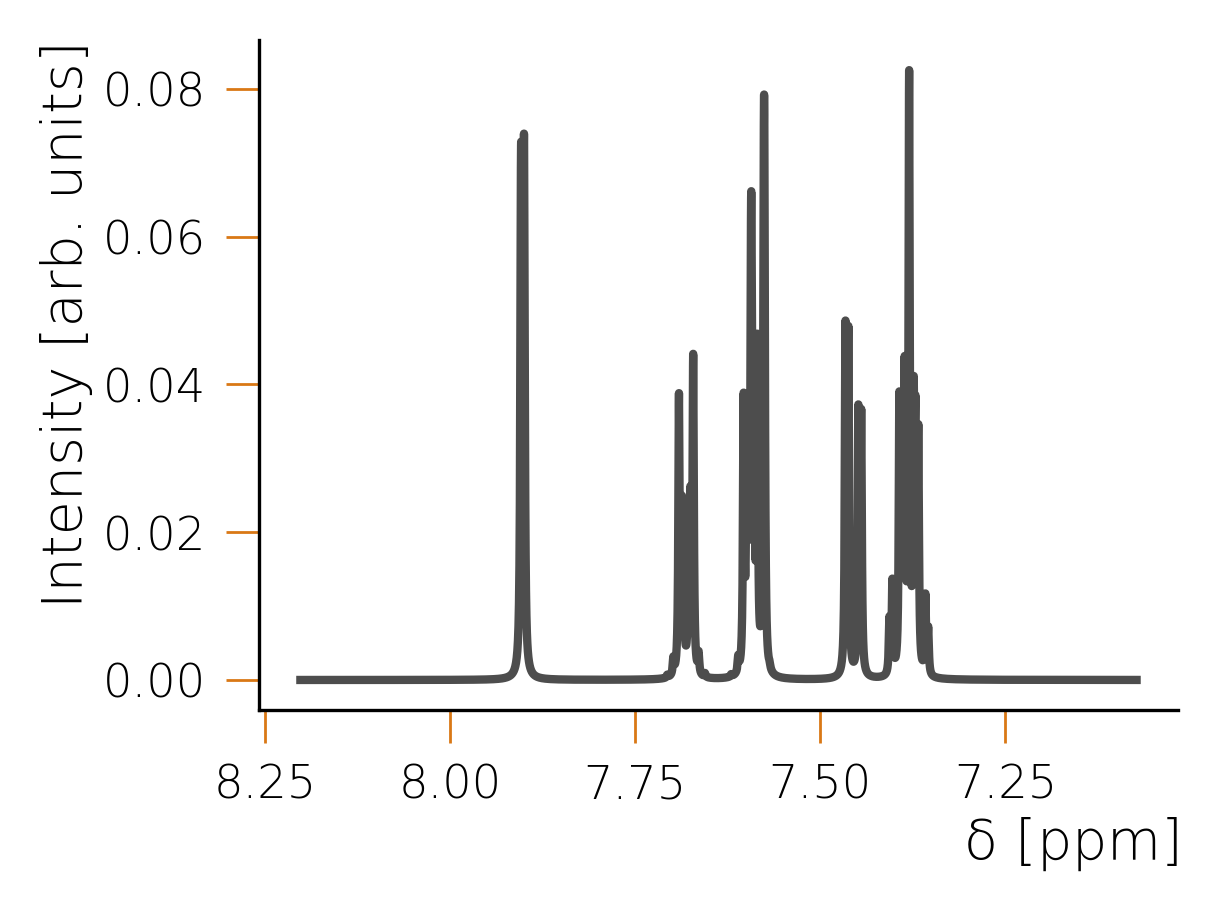

In [11]:
intensities = np.sum(spin_contributions, axis=0)

plt.plot(omegas_ppm, intensities)
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")

# Invert the frequency axis as is standard in NMR spectroscopy.
plt.gca().invert_xaxis()

plt.show()

## Clustering

Now that we know how we can obtain a spectrum, let us discuss our clustering approach as a possible approximation scheme. Note that the NMR solvers in HQS Spectrum Tools can only evaluate the spectra of pure NMR Hamiltonians, so Hamiltonians of the form:

$$
\begin{align}
\hat{H} = -\sum_l \gamma_l \left( 1 + \delta_l \right) B^z  \hat{I}^z_l + 2 \pi\sum_{k < l} J_{kl}  \mathbf{\hat I}_k \cdot \mathbf{\hat I}_l \, ,
\end{align}
$$

where $\gamma_l$ is the gyromagnetic factor and  $\delta_l$ the chemical shift of nuclear spin $l$.
$J_{kl}$ denotes the coupling between spins $k$ and $l$ and $\hat{I}^\alpha=\hat{S}^\alpha / \hbar$ where the $\hat{S}^\alpha$ are the usual SU(2) spin operators with $\alpha \in \{x, y, z\}$.

Our [spin-dependent clustering approach](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/background/solver.html) achieves this, by identifying for each spin only the terms in the Hamiltonian related to the spins most strongly coupled to it. One then has to solve for the spin contribution of each spin separately and combine the individual spin contributions in the end. This can conveniently be achieved using the `cluster_molecule` function. Since the molecule we chose only has seven spins, we are going to put the `maximum_cluster_size` to 4 using a `NMRSolverSettings` object:

In [12]:
solver_settings = NMRSolverSettings(max_cluster_size=4)
cluster_dict_list = cluster_molecule(
    molecule_parameters,
    calculation_parameters.gyromagnetic_ratios,
    calculation_parameters.field_T,
    solver_settings,
    calculation_parameters.reference_isotope,
)
print("Number of identified clusters: ", len(cluster_dict_list))

Number of identified clusters:  2


The function returns a list of dictionaries, where each dictionary contains information on one cluster. In this case, two clusters where identified. If you go through the Hamiltonian output above, you will notice, that there are no J-coupling entries between the spins with indices {0, 1, 2} and those with indices {3, 4, 5, 6}. Therefore we would expect these sets of indices to be identified as individual clusters. To check this let us take a look at the two dictionaries:


In [13]:
cluster_dict_list[0]

{'spin_contribution_indices_in_molecule': [0, 1, 2],
 'spin_contribution_indices_in_cluster': [0, 1, 2],
 'cluster_indices': [0, 1, 2],
 'nmr_parameters': NMRParameters(isotopes=[Isotope(mass_number=1, symbol='H'), Isotope(mass_number=1, symbol='H'), Isotope(mass_number=1, symbol='H')], shifts=[7.902, 7.456, 7.584], j_couplings=[((0, 1), 1.95), ((0, 2), 0.4), ((1, 2), 8.7)]),
 'use_local_su2': False}

In [14]:
cluster_dict_list[1]

{'spin_contribution_indices_in_molecule': [3, 4, 5, 6],
 'spin_contribution_indices_in_cluster': [0, 1, 2, 3],
 'cluster_indices': [3, 4, 5, 6],
 'nmr_parameters': NMRParameters(isotopes=[Isotope(mass_number=1, symbol='H'), Isotope(mass_number=1, symbol='H'), Isotope(mass_number=1, symbol='H'), Isotope(mass_number=1, symbol='H')], shifts=[7.594, 7.373, 7.388, 7.681], j_couplings=[((0, 1), 7.8), ((0, 2), 1.45), ((0, 3), 0.1), ((1, 2), 6.7), ((1, 3), 1.4), ((2, 3), 8.2)]),
 'use_local_su2': False}

As we can see, the entry `cluster_indices` for both elements of the list contain the expected indices, so the method worked as anticipated. Now let's discuss the other elements in detail:

Since our custering approach is spin-dependent, each cluster has associated **spin contributions**. These basically describe the spin indices, for which to evaluate the contribution to the spectral function using this cluster. Since we are identifying clusters for each spin individually, you will often find only one element in the list of spin contributions. However, if multiple spins are associated with the same cluster (as in our case) they will be grouped together. Furthermore, we distinguish between the `spin_contribution_indices_in_molecule`, which are the indices of the spins in the original Hamiltonian and `spin_contribution_indices_in_cluster`, which are the indices in the cluster Hamiltonian. The entry `use_local_su2` tells you, whether it is beneficial to exploit local SU(2) symmetry when solving a given cluster. Finally, if you want to obtain the `struqture` Hamiltonian just for one cluster you can do so using the `nmr_parameters` entry:

In [15]:
cluster_0_parms = cluster_dict_list[0]["nmr_parameters"]
struqture_cluster_0_hamiltonian = nmr_hamiltonian(
    parameters=cluster_0_parms,
    field=calculation_parameters.field_T,
    reference_isotope=calculation_parameters.reference_isotope,
)
print(struqture_cluster_0_hamiltonian)

PauliHamiltonian{
0Z: -1.2412432385206223e4,
1Z: -1.1711857234477997e4,
2Z: -1.1912919161081314e4,
0X1X: 3.0630528372500483e0,
0Y1Y: 3.0630528372500483e0,
0Z1Z: 3.0630528372500483e0,
0X2X: 6.283185307179586e-1,
0Y2Y: 6.283185307179586e-1,
0Z2Z: 6.283185307179586e-1,
1X2X: 1.36659280431156e1,
1Y2Y: 1.36659280431156e1,
1Z2Z: 1.36659280431156e1,
}


In [16]:
cluster_1_parms = cluster_dict_list[1]["nmr_parameters"]
struqture_cluster_1_hamiltonian = nmr_hamiltonian(
    parameters=cluster_1_parms,
    field=calculation_parameters.field_T,
    reference_isotope=calculation_parameters.reference_isotope,
)
print(struqture_cluster_1_hamiltonian)

PauliHamiltonian{
0Z: -1.1928627124071121e4,
1Z: -1.1581481141328812e4,
2Z: -1.1605043085813522e4,
3Z: -1.2065286402463913e4,
0X1X: 1.2252211349000193e1,
0Y1Y: 1.2252211349000193e1,
0Z1Z: 1.2252211349000193e1,
0X2X: 2.2776546738526e0,
0Y2Y: 2.2776546738526e0,
0Z2Z: 2.2776546738526e0,
0X3X: 1.5707963267948966e-1,
0Y3Y: 1.5707963267948966e-1,
0Z3Z: 1.5707963267948966e-1,
1X2X: 1.0524335389525808e1,
1Y2Y: 1.0524335389525808e1,
1Z2Z: 1.0524335389525808e1,
1X3X: 2.199114857512855e0,
1Y3Y: 2.199114857512855e0,
1Z3Z: 2.199114857512855e0,
2X3X: 1.288052987971815e1,
2Y3Y: 1.288052987971815e1,
2Z3Z: 1.288052987971815e1,
}


Now you know how to obtain the spectrum for any NMR Hamiltonian in `struqture` format and you know how to extract cluster Hamiltonians from given molecular parameters. Therefore, you have all the information needed to code up your own spin-dependent cluster solver. We leave this as an exercise to the reader as it is a good starting point to get familiar with the functions provided by **HQS Spectrum Tools**. If you want to try it, take care of the distinction between the indices in the molecule and the indices in the cluster mentioned above.
 